## 1. Import

In [26]:
import os
import sys
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())
print(f"Aktuelles Arbeitsverzeichnis: {os.getcwd()}")

Aktuelles Arbeitsverzeichnis: c:\Users\hp\OneDrive\Desktop\DBU\wai81-ai-theory\ml_picture_recognition


In [ ]:
# 1. Bibliotheken importieren
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from utils.model import HockeyActionModelResNet18   # Modell aus model.py
from utils.dataloader import HockeyDataset  # DataLoader aus dataloader.py
from utils.transforms import train_transform, val_transform # fuer die Augmentierung
from sklearn.metrics import classification_report, confusion_matrix
import random
import os 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

## 2. Device & Hyperparameter


In [28]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
NVIDIA RTX A5000 Laptop GPU


In [29]:
# 2. Device auswählen
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Benutze Gerät: {device}")

Benutze Gerät: cuda


In [30]:
# Konfiguration
batch_size = 4
num_epochs = 30
frames_per_clip = 100

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


## 3. Dataset & Dataloader

In [32]:
# Datensätze direkt aus fixen CSV-Dateien laden (zuvor erzeugt)
train_dataset = HockeyDataset('data/labels_train.csv', 'data/train_frames', transform=train_transform, frames_per_clip=frames_per_clip)
val_dataset   = HockeyDataset('data/labels_val.csv', 'data/train_frames', transform=val_transform, frames_per_clip=frames_per_clip)

# Dataloader für Training und Validierung
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


## 4. Model + Loss + Optimizer 

In [ ]:
model = HockeyActionModelResNet18().to(device)              # Modell auf GPU/CPU laden
criterion = criterion = nn.BCEWithLogitsLoss()              # Verlustfunktion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimierer

# Lernraten-Scheduler: reduziert LR, wenn val_loss stagniert
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)


c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


## 5. Trainingsloop

In [34]:
# Container für Trainings- und Validierungsverluste und F1-Scores
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

In [ ]:
best_val_f1 = 0                             # Bisher bester validierter F1-Score
best_epoch = 0                              # Epochenzähler für besten Stand
early_stopping_counter = 0                  # Zähler für Early Stopping
patience = 5                                # Max. Anzahl an Epochen ohne Verbesserung

# Optional: Scheduler (erst aktivieren, wenn du willst)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

for epoch in range(num_epochs):
    model.train()                           # Setzt das Modell in Trainingsmodus (Dropout aktiv etc.)
    running_loss = 0.0                      # Akkumuliert Loss pro Epoche
    all_preds, all_targets = [], []         # Für F1-Berechnung

    for frames, labels in train_loader:
        frames = frames.to(device)                         # [B, T, 3, 224, 224]
        labels = labels.float().to(device)                 # Multi-Label: [B, 4] als Float-Tensor

        outputs = model(frames)                            # Raw Logits, Shape: [B, 4]
        loss = criterion(outputs, labels)                  # Multi-Label Loss (z. B. BCEWithLogitsLoss)

        optimizer.zero_grad()                              # Gradienten auf 0 setzen
        loss.backward()                                    # Backpropagation: Gradienten berechnen
        optimizer.step()                                   # Parameterupdate mit Adam o.ä.

        running_loss += loss.item()                        # Loss aufaddieren für Mittelwert später
        preds = (torch.sigmoid(outputs) > 0.5).float()     # Sigmoid + Schwellenwert → binäre Vorhersage
        all_preds.append(preds.detach().cpu())             # Detach + auf CPU → nicht im Rechengraph
        all_targets.append(labels.detach().cpu())          # Zielwerte ebenfalls auf CPU sammeln

    train_loss = running_loss / len(train_loader)          # Durchschnittlicher Loss pro Batch
    train_f1 = f1_score(torch.cat(all_targets), torch.cat(all_preds), average="macro", zero_division=0)

    train_losses.append(train_loss)                        # Speichern für Plotting
    train_f1_scores.append(train_f1)

    # VALIDIERUNG
    model.eval()                                            # Schaltet z. B. Dropout & BatchNorm aus
    val_loss = 0.0
    val_preds, val_targets = [], []

    with torch.no_grad():                                  # Kein Gradienten-Tracking nötig
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.float().to(device)

            outputs = model(frames)                        # Vorhersage
            loss = criterion(outputs, labels)              # Loss berechnen

            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float() # Binäre Schwellenwert-Entscheidung
            val_preds.append(preds.detach().cpu())
            val_targets.append(labels.detach().cpu())

    val_loss /= len(val_loader)
    val_f1 = f1_score(torch.cat(val_targets), torch.cat(val_preds), average="macro", zero_division=0)

    val_losses.append(val_loss)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, F1 {train_f1:.2f} | Val Loss {val_loss:.4f}, F1 {val_f1:.2f}")

    # Optional: Scheduler-Update (z. B. bei Plateaus)
    # scheduler.step(val_f1)

    # EARLY STOPPING
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1                              # Bestwert aktualisieren
        best_epoch = epoch + 1                            # Merke beste Epoche (1-basiert)
        early_stopping_counter = 0                        # Zähler zurücksetzen
        torch.save(model.state_dict(), "best_resnet18_lstm.pth")  # Modell speichern
    else:
        early_stopping_counter += 1
        print(f"Early Stopping Counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}. Best epoch: {best_epoch}")
            break


Epoch 1: Train Loss 0.5592, F1 0.28 | Val Loss 0.8226, F1 0.27
Epoch 2: Train Loss 0.5187, F1 0.39 | Val Loss 0.5311, F1 0.46
Epoch 3: Train Loss 0.4907, F1 0.45 | Val Loss 0.5645, F1 0.30
Early Stopping Counter: 1/5
Epoch 4: Train Loss 0.4774, F1 0.43 | Val Loss 0.5061, F1 0.34
Early Stopping Counter: 2/5
Epoch 5: Train Loss 0.4663, F1 0.47 | Val Loss 0.4754, F1 0.25
Early Stopping Counter: 3/5
Epoch 6: Train Loss 0.4441, F1 0.47 | Val Loss 0.4823, F1 0.51
Epoch 7: Train Loss 0.4500, F1 0.52 | Val Loss 0.4450, F1 0.45
Early Stopping Counter: 1/5
Epoch 8: Train Loss 0.4112, F1 0.46 | Val Loss 0.4481, F1 0.52
Epoch 9: Train Loss 0.3858, F1 0.51 | Val Loss 0.4881, F1 0.51
Early Stopping Counter: 1/5
Epoch 10: Train Loss 0.4334, F1 0.52 | Val Loss 0.4426, F1 0.52
Early Stopping Counter: 2/5
Epoch 11: Train Loss 0.4120, F1 0.50 | Val Loss 0.4594, F1 0.52
Early Stopping Counter: 3/5
Epoch 12: Train Loss 0.3861, F1 0.54 | Val Loss 0.4993, F1 0.49
Early Stopping Counter: 4/5
Epoch 13: Train L

## 6. Plot Training und Validation

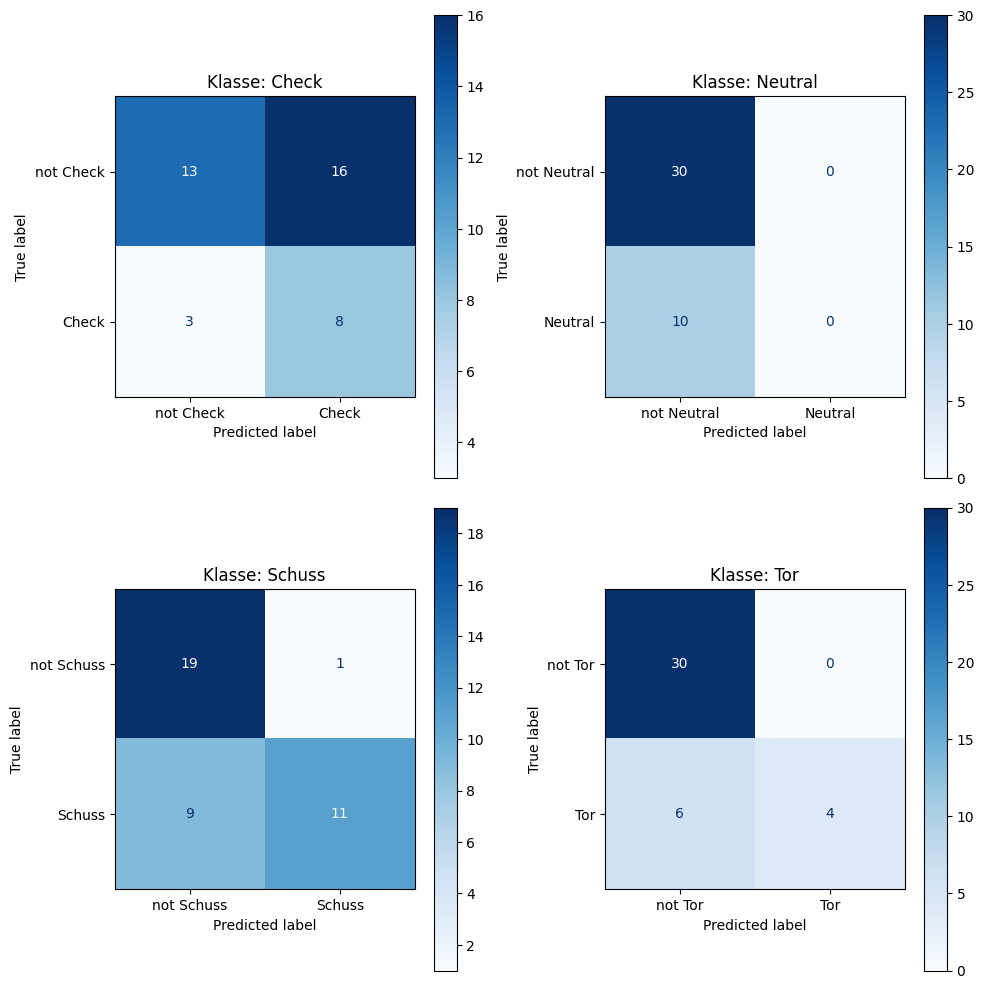

In [ ]:
# Klassen-Labels
class_names = ['Check', 'Neutral', 'Schuss', 'Tor']

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for frames, labels in val_loader:
        frames = frames.to(device)
        labels = labels.to(device)

        outputs = model(frames)
        predicted = (torch.sigmoid(outputs) > 0.5).int()

        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu().int())

# Tensors stapeln
all_preds = torch.cat(all_preds).numpy()  # Shape [N, 4]
all_labels = torch.cat(all_labels).numpy()

# Multilabel Confusion Matrix (eine 2x2-Matrix pro Klasse)
mcm = multilabel_confusion_matrix(all_labels, all_preds)

# Plot: jede Klasse einzeln anzeigen
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(len(class_names)):
    ConfusionMatrixDisplay(
        confusion_matrix=mcm[i],
        display_labels=[f'not {class_names[i]}', class_names[i]]
    ).plot(ax=axes[i], cmap='Blues', values_format='d')
    axes[i].set_title(f"Klasse: {class_names[i]}")

plt.tight_layout()
plt.show()


In [ ]:
print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

       Check       0.33      0.73      0.46        11
     Neutral       0.00      0.00      0.00        10
      Schuss       0.92      0.55      0.69        20
         Tor       1.00      0.40      0.57        10

   micro avg       0.57      0.45      0.51        51
   macro avg       0.56      0.42      0.43        51
weighted avg       0.63      0.45      0.48        51
 samples avg       0.47      0.41      0.43        51



c:\Users\hp\anaconda3\envs\picture\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\anaconda3\envs\picture\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


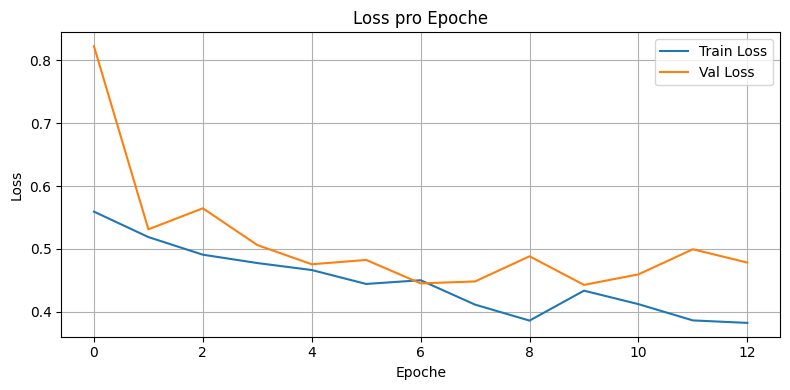

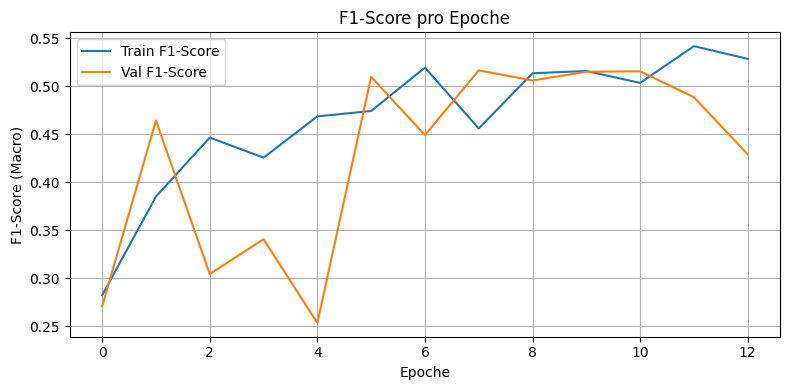

In [ ]:
# Loss-Verlauf
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.title('Loss pro Epoche')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1-Verlauf (statt Accuracy)
plt.figure(figsize=(8, 4))
plt.plot(train_f1_scores, label='Train F1-Score')
plt.plot(val_f1_scores, label='Val F1-Score')
plt.xlabel('Epoche')
plt.ylabel('F1-Score (Macro)')
plt.title('F1-Score pro Epoche')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Modell speichern

In [40]:
os.makedirs('models', exist_ok=True)
torch.save(model.state_dict(), 'models/best_resnet18_lstm.pth')
print("✅ Modell erfolgreich gespeichert.")


✅ Modell erfolgreich gespeichert.
